In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import date
from lmfit.models import  GaussianModel, ExponentialGaussianModel
from lmfit import Model
'imports done'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


'imports done'

In [2]:
data = pd.read_csv('../data/covid/covid_19_data.csv')
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
data['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

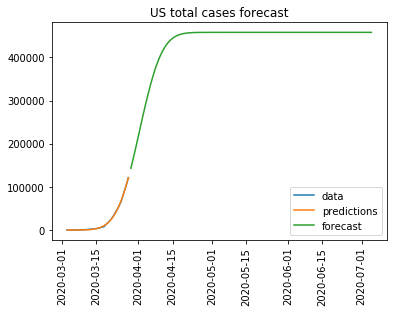

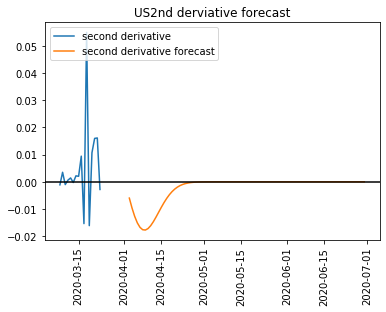

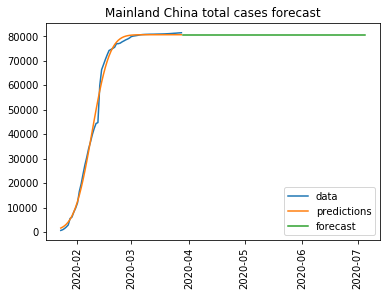

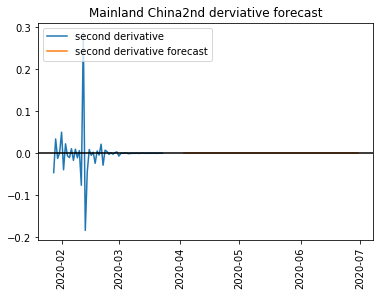

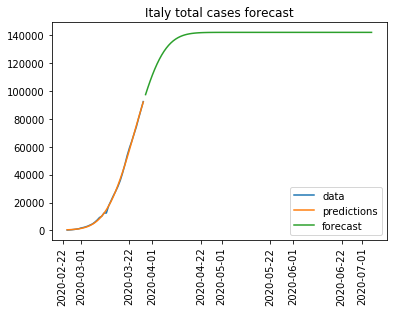

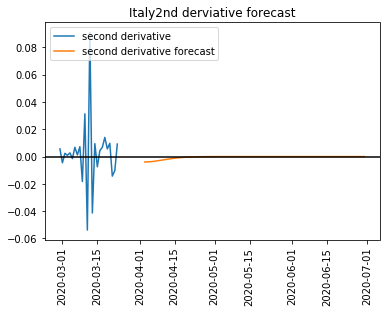

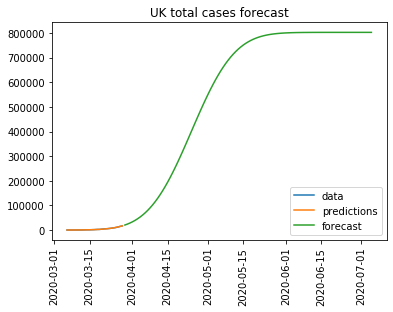

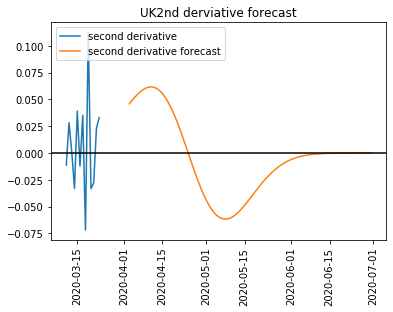

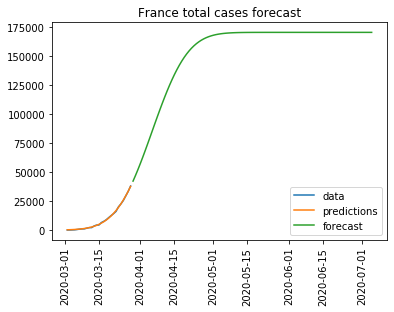

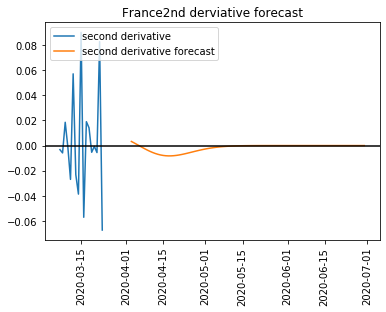

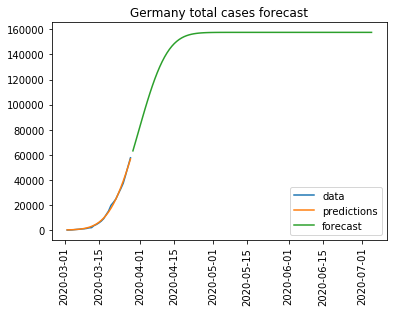

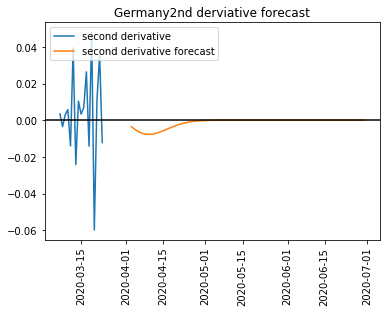

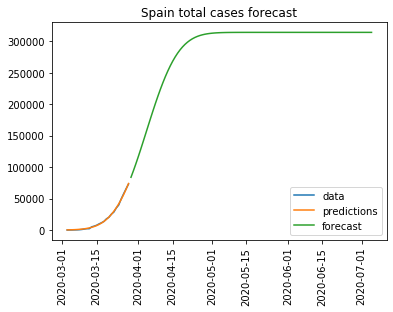

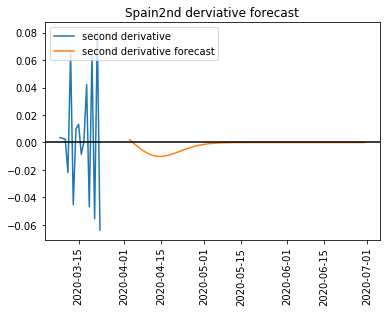

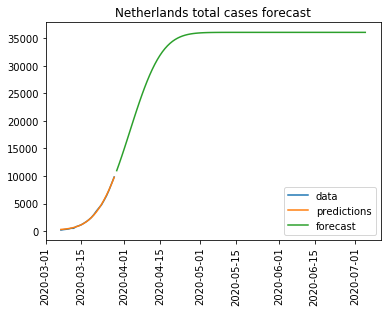

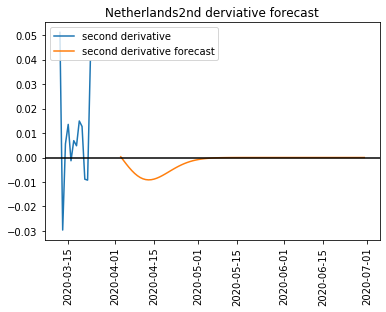

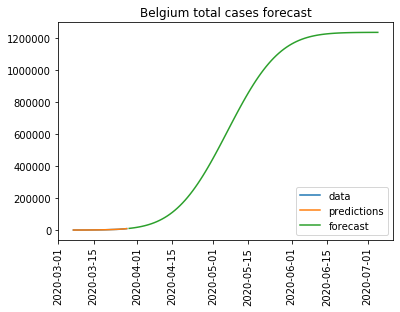

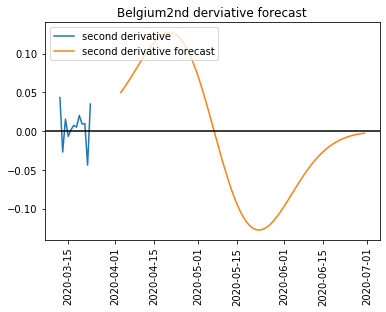

In [42]:
from scipy.stats import norm
from datetime import timedelta
from scipy.interpolate import UnivariateSpline



def aggregate(data, column, value, groupby_variable, aggregator):
    return data[data[column] == value].groupby([groupby_variable]).agg(aggregator).reset_index()

def gaussian_cdf(x, amp, cen, wid):
    value = norm.cdf(x, cen, wid) * amp
    return value

countries = ['US', 'Mainland China', 'Italy', 'UK', 'France', 'Germany','Spain','Netherlands','Belgium']


    
output_scaler = MinMaxScaler()


gmodel = Model(gaussian_cdf)
params = gmodel.make_params(cen=0, amp=1, wid=1)
for country in countries:
    country_data = aggregate(data, 'Country/Region', country, 'ObservationDate', 'sum')
    country_data['ObservationDate'] = pd.to_datetime(country_data['ObservationDate'])
    index_data = country_data[country_data['Confirmed'] > 100].sort_values(by=['ObservationDate']).head(1)
    
    country_data = country_data[country_data.ObservationDate > index_data.ObservationDate.values[0]]
    X = ((country_data['ObservationDate'] - index_data.ObservationDate.values[0]).dt.days).values.reshape((-1, 1))
    Y = output_scaler.fit_transform(country_data['Confirmed'].values.reshape((-1, 1)))
    

    
    result = gmodel.fit(Y, params, x= X)
    
    forecast = X[-1] + range(1, 100)
    
    
    
    forecast_dates = [ pd.to_datetime(country_data['ObservationDate'].values[-1]) + timedelta(days = i) for i in range(1, 100)]
    predictions = gaussian_cdf(forecast, result.params['amp'].value, result.params['cen'].value, result.params['wid'].value)
    
    #print(index_data.ObservationDate.dt.date.values[0])
    
    X_date = country_data['ObservationDate'].values
    #print(X_date)
    

    
    plt.title(country + ' total cases forecast')
    plt.plot(X_date, output_scaler.inverse_transform(Y), label = 'data')
    plt.plot(X_date, output_scaler.inverse_transform(result.best_fit), label = 'predictions')
    plt.plot(forecast_dates, output_scaler.inverse_transform(predictions.reshape((-1, 1))), label = 'forecast')
    plt.xticks(rotation = 90)
    plt.legend(loc='lower right')
    plt.show()
    
    Y_2D = (UnivariateSpline(X, Y,s=0,k=2)).derivative(n=2)
    forecast_2D = UnivariateSpline(forecast, predictions,s=0,k=2).derivative(n=2)
    
    plt.title(country + '2nd derviative forecast')
    plt.plot(X_date[5:-5], Y_2D(X[5:-5]), label = 'second derivative')
    plt.plot(forecast_dates[5:-5], forecast_2D(forecast[5:-5]), label = 'second derivative forecast')
    plt.axhline(0, color = 'black')
    plt.xticks(rotation = 90)
    plt.legend(loc='upper left')
    plt.show()
    

    